System: 


initial pulse: $\Omega(t)^0$

total pulse length : $T_f$

$$ H_0 = \Omega/4
\begin{pmatrix}
    0 & 1 & 0 & 0 \\
    1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1\\
    0 & 0 & 1 & 0
\end{pmatrix}. $$

$$ H_J = J/2
\begin{pmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & -1 & 0\\
    0 & 0 & 0 & 1
\end{pmatrix}. $$


$$ H_{total} = H_0+H_J $$

-------------------------------
initial
--------
$\Omega^0(t)=-np.genfrontxt$

$H_{total}^0 \rightarrow U_{total}^0 \rightarrow G_1, G_2 \rightarrow fcost$



-------------------------------
CRAB
--------
$Nc=4$

{An,Bn}={000...}

$wn=\frac{2 pi n}{Tf}+random[-0.5,0.5]$

$g(t)=1+\sum An sin(wn t)+ Bn cos(wn t)$

$\Omega^{CRAB}(t)=\Omega^0(t).g(t)$

$H_{total}^{CRAB} \rightarrow U_{total}^{CRAB} \rightarrow G_1, G_2 \rightarrow fcost$

minimize(fcost, {An,Bn},method='Nelder-Mead')




In [369]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from double_qd_trotter_funcs import *
from scipy import interpolate
from scipy.linalg import expm
from numpy.linalg import det

38.027760612129306
1.479790653434501


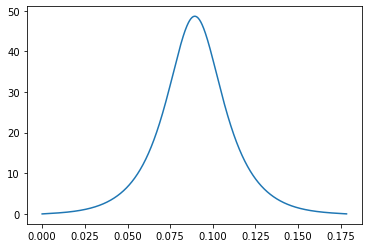

In [370]:
#initoal pulse: Omega0(t)
OmegaData = -np.genfromtxt('pulse_tau01783393782206284.csv')

#interpolate into time-dep function Omega0(t)
x = np.linspace(0,Tf, num=len(OmegaData))
Omega0 = interpolate.interp1d(x, OmegaData)

Omega0_plot = Omega0(x)
plt.plot(x,Omega0_plot)
print(Omega0(0.1))
h0 = np.diag(np.array([1, 0, 1]),1)+np.diag(np.array([1, 0, 1]),-1)
hJ = np.diag(np.array([0, 0, -1,1]))
J=19.7
Tf = 0.1783393782206284
print(Omega0(0.15))

In [79]:
def print_properties(obj):
        print(f"Properties of object {type(obj).__name__}:")
        print("-"*40)
        for attr in dir(obj):
            if not attr.startswith("__"):
                print(f"{attr}: {getattr(obj,attr)}")
        print("-"*40)

In [371]:
# Initialize Hamiltonian
h0 = np.diag(np.array([1, 0, 1]),1)+np.diag(np.array([1, 0, 1]),-1)
hJ = np.diag(np.array([0, 0, -1,1]))
J=19.7
Tf = 0.1783393782206284
print("h0=")
print(h0)
print("")
print("hJ=")
print(hJ)

h0=
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]

hJ=
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]


In [638]:
#class
class Hamiltonian:
    def __init__(self, Omega):
        self.Omega = Omega
        self.originalOmega = Omega
        self.U = None
        self.setOmega(self.Omega)
        self.Utrotter()
        self.Marklin_Invariant()
        self.G = None
        Tf = 0.1783393782206284
    
    
    def setOmega(self, Omega):
        self.Omega = Omega
        return self
        
        
    def H(self, t):
        J=19.7
        return self.Omega(t)/4 * h0 + J/2 * hJ 
    
    
    #Utrotter
    def Utrotter(self):
        Nstep=500
        U = np.eye(4)
        delta_t = Tf / Nstep
        for n in range(Nstep):
            Un = expm(-1j* self.H(delta_t * n) * (delta_t))
            U = U @ Un
            
        self.U = U
        
        return self.U
        
        
    #Marklin_Invariant
    def Marklin_Invariant(self):
        self.Q = np.array([[1,0,0,1j],[0,1j,1,0],[0,1j,-1,0],[1,0,0,-1j]]) / np.sqrt(2)
        self.UB = self.Q.conj().T @ self.U @ self.Q
        
        self.m = np.dot(self.UB.T , self.UB)
        
        self.G1 = (np.trace(self.m)**2 * np.linalg.det(self.U.conj().T) )/16  
        self.G2 = (np.trace(self.m)**2 - np.trace(self.m @ self.m)) * np.linalg.det(self.U.conj().T)/4
        self.fcost = abs(self.G1)**2 + abs(self.G2 - 1)**2
    
        return self.fcost
    
    def updateOmega(self, g, update = True):
        tlist = np.linspace(0,Tf, num=len(OmegaData))
        #vectorize creates a new fucntion that applies the g(t) function to every element in array tlist and returns an array
        glist = np.vectorize(g)(tlist)
        #we recover the original pulse from the interpolation object
        oriOmega = np.vectorize(self.originalOmega)(tlist)
        #do Omega(t) * g(t)
        newOmega = oriOmega * glist
        #Interpolate results and set Omega to the new function
        self.Omega = interpolate.interp1d(tlist, newOmega)
        if (update):
            self.Utrotter()
            self.Marklin_Invariant()
        return self

    

In [639]:
# G is an object that operates as both a class and a function
# This allows instances of G to be called as g(t), which will run the code in __call__
# At the same time, instances of G can be parameterized, and the parameters can be updated with G.update_parameters()
class G:
    def __init__(self, A,B):
        print(A)
        self.A = A
        self.B = B
        
    def __call__(self, t):
        Nc = 4      #size = 4
        w = np.zeros(Nc)
        gsol = 1
        for n in range(Nc):
            w[n] = 2 * np.pi * n /Tf + np.random.uniform(-0.5,0.5)   #frequence with randomn from [-0.5,0.5]
            gsol += self.A[n] * np.sin(w[n]*t) + self.B[n] * np.cos(w[n]*t)
            
        return gsol
    
    def update_parameters(self, newA, newB):
        self.A = newA
        self.B = newB
        return self

In [646]:
myH = Hamiltonian(Omega0)

g = G(alist, blist)
myH.setG(g)

def callbackMin(cb):
    callbackMin.counter += 1
    if callbackMin.counter % 10 == 0:
        print("Paramters: ", cb)
        
callbackMin.counter = 0

def searchfCost(M, G, H):
    M = M.reshape(2,4)
    G.update_parameters(M[0], M[1])
    H.updateOmega(G)
    return H.fcost
time = timer()
result = minimize(searchfCost, np.zeros((2,4)), args=(g, myH), method='Nelder-Mead')
time = timer()-time
print(time)

[1. 1. 1. 1.]
40.321316412999295


In [ ]:
fresult = result

In [681]:
myResult =result
print(searchfCost(myResult.x, g, myH))
print(myH.Omega)

1.1007786562144131e-17


In [677]:
#print(myResult)
print(searchfCost(myResult.x, g, myH))
print(searchfCost(np.array([0.01722199,0.10328865,0.02743889,-0.07120934,-0.07129489,0.10680203,-0.02104302,-0.05499698]), g, myH))

9.758009129481122e-19
5.632834324273244e-10


In [431]:
#Crab_ g(t) function

def newOmega(A, B, t):
    Nc = len(A)      #size = 4
    w = np.zeros(Nc)
    gsol = 1
    for n in range(Nc):
        w[n] = 2 * np.pi * n /Tf + np.random.uniform(-0.5,0.5)  
        gsol += A[n] * np.sin(w[n] * t) + B[n] * np.cos(w[n]*t)
    
    tlist = np.linspace(0,Tf, num=len(OmegaData))
    glist = np.ndarray(g(tlist))
    newOmega = interpolate.interp1d(tlist, glist)
    return newOmega



minimize(myHam(newOmega(A,B,t))., {A,B}, method='Nelder-Mead', tol=1e-6)
        res.x


minimize(myHam(Omega0*g(A,B,t)).fcost, {A,B}, method='Nelder-Mead', tol=1e-6)
        res.x

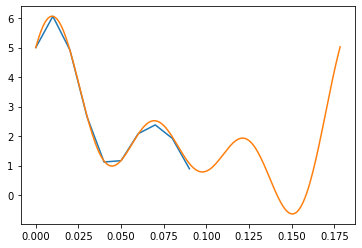

In [428]:
alist = np.ones(4)
blist = np.ones(4)
g(alist,blist, Tf, 0.01)

t = [x/100 for x in range(10)]
y = [g(alist, blist, Tf, t) for t in t]

plt.plot(t, y)



#interpolate into time-dep function Omega0(t)
x_plot = np.linspace(0,Tf, num=200)
y_plot = g(alist,blist, Tf, x_plot)

plt.plot(x_plot,y_plot)

In [401]:
myH= Hamiltonian(Omega0)
#print(myH.Utrotter())
print(myH.H)
myH.Omega = myH.Omega*g(t)

<bound method Hamiltonian.H of <__main__.Hamiltonian object at 0x1241a0bb0>>


In [ ]:
thisHam = Hamiltonian(Omega0)
print(thisHam.Omega)
print(thisHam.Omega)



In [411]:
#Crab
#g(A,B,t)

#size = 4


def g(A, B):
    Nc = len(A)
    w = np.zeros(Nc)
    gsol = 1
    for n in range(Nc):
        w[n] = 2 * np.pi * n /Tf + np.random.uniform(-0.5,0.5)  
        gsol += A[n] * np.sin(self.w[n] * t) + B[n] * np.cos(self.w[n]*t)
    
    return g(t)


In [410]:
np.random.uniform(-0.5,0.5)

-0.06961294756274261

In [44]:
thisHam = Hamiltonian(Omega0)
print(thisHam.Omega)
print(thisHam.Omega)

In [22]:
thisHam = Hamiltonian(Omega0)
print(thisHam.Omega)
print(thisHam.Omega)

#minimize

myHam = Hamiltonian(Omega0)

myHam.H(.05)
        

array([[ 0.        ,  1.66756201,  0.        ,  0.        ],
       [ 1.66756201,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -9.85      ,  1.66756201],
       [ 0.        ,  0.        ,  1.66756201,  9.85      ]])

In [ ]:
res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)
        res.x

Marklin Invariant
--------
$Q=
\begin{pmatrix}
    1 & 0 & 0 & i \\
    0 & i & 1 & 0 \\
    0 & i & -1 & 0\\
    1 & 0 & 0 & -i
\end{pmatrix}. $

$U_B=Q^{+}UQ$

$M=U_B^T.U_B$

$G_1=\frac{Tr[M]^2 *det[U^+]}{16det[U]}$

$G_2=\frac{(Tr[M]^2-Tr[M^2])*det[U^+]}{4d}$

$fcost=|G_1|^2+|G_2-1|^2$

In [56]:
#Class for Marklin Invariants


class Marklin_Invariant:
    def __init__(self, U):
        self.U = U
        self.Q = np.array([[1,0,0,1j],
                          [0,1j,1,0],
                          [0,1j,-1,0],
                          [1,0,0,-1j]])
        self.UB = np.dot(self.Q.conj().T,self.U,self.Q)
        self.m = np.dot(self.UB.transpose(),self.UB)
        self.G1= np.dot(np.trace(self.m),np.trace(self.m)*np.linalg.det(U))/(16*np.linalg.det(U))
        self.G2= (np.dot(np.trace(self.m),np.trace(self.m))-np.trace(np.dot(self.m,self.m)))*np.linalg.det(U)/(4)


In [57]:
U= np.array([[1,0,0,0],
                [0,1,0,0],
                [0,0,0,1],
                [0,0,1,0]])
myMI=Marklin_Invariant(U)

In [58]:
print(myMI.G1)
print(myMI.G2)
print(myMI.Q)

-0j
(4-0j)
[[ 1.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j  0.+0.j  0.-1.j]
 [ 0.+0.j  1.+0.j  0.+0.j -1.+0.j]
 [ 0.-1.j  0.+0.j  0.+1.j  0.+0.j]]


Initial  Guess 
----------------
$H_{origin}=h_0 \Omega0(t)+J* hJ$



In [85]:
Omega0(0.11)

array(22.3986254)

In [106]:
#Initial guess

class myGuess:
    def __init__(self,Omega0):
        
        #self.Horigin = self.getHorgin()
        self.Nstep=500
        self.duration =Tf
        
        self.U = np.eye(4)
        delta_t=self.duration/self.Nstep
        for n in range(self.Nstep):
            self.U = np.dot(self.U,np.exp(-1j* self.H(delta_t*n)* delta_t))
            
    def H(self, t):
        return Omega0(t)/4 * h0 +J/2 * hJ
    


In [107]:
myOrigin=myGuess(Omega0)

In [110]:
myMI = Marklin_Invariant(myOrigin.U)
myMI.G2

(nan+nanj)

CRAB
--------
$Nc=4$

{An,Bn}={000...}

$wn=\frac{2 pi n}{Tf}+random[-0.5,0.5]$

$g(t)=1+\sum An sin(wn t)+ Bn cos(wn t)$

$\Omega^{CRAB}(t)=\Omega^0(t).g(t)$

$H_{total}^{CRAB} \rightarrow U_{total}^{CRAB} \rightarrow G_1, G_2 \rightarrow fcost$

minimize(fcost, {An,Bn},method='Nelder-Mead')

--------------------------


class myGuess:
    def __init__(self,Omega0):
        
        #self.Horigin = self.getHorgin()
        self.Nstep=500
        self.duration =Tf
        
        self.U = np.eye(4)
        delta_t=self.duration/self.Nstep
        for n in range(self.Nstep):
            self.U = np.dot(self.U,np.exp(-1j* self.H(delta_t*n)* delta_t))
            
    def H(self, Omega, t):
        J=19.7
        return Omega(t)/4 * h0 +J/2 * hJ

In [ ]:
# CRAB

class myCRAB:
    def __init__(self,Omega0):
        
        self.Omega0 = Omega0
        self.H0 = self.H(Omega0,t)
        self.U0 = self.Utrotter(self.H0)
        print (self.U0.)
        res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)
        res.x
        
        
    def Hnew(self, Omega, t):
        J=19.7
        return Omega(t)/4 * h0 +J/2 * hJ
    
    
    
    def Utrotter(self,self.H):
        self.Nstep=500
        self.duration =Tf
        
        Usolve = np.eye(4)
        delta_t=self.duration/self.Nstep
        for n in range(self.Nstep):
            Usolve = np.dot(Usolve,np.exp(-1j* self.H(Omega,delta_t*n)* delta_t))
            
        return self.U0
            
    
    def FourierCorrection(self, Nc=4, A, B, t):
        self.Nc = Nc
        self.A = A
        self.B = B
        self.w = np.zeros(self.Nc)
        self.g0=1
        for n in range(self.Nc):
            self.w[n]=2*np.Pi*n /Tf + np.random.uniform(-0.5,0.5)   #? T?
            self.g0 = self.g0 + self.A[n]*np.sin(self.w[n]*t) + self.B[n]*np.cos(self.w[n]*t)
            
        return self.g0(t)

        
    def Marklin_Invariant(self, U):
        self.U = U
        self.Q = np.array([[1,0,0,1j],
                          [0,1j,1,0],
                          [0,1j,-1,0],
                          [1,0,0,-1j]])
        self.UB = np.dot(self.Q.conj().T,self.U,self.Q)
        self.m = np.dot(self.UB.transpose(),self.UB)
        self.G1 = np.dot(np.trace(self.m),np.trace(self.m)*np.linalg.det(U))/(16*np.linalg.det(U))
        self.G2 = (np.trace(self.m)**2-np.trace(self.m**2))*np.linalg.det(U)/(4)
        self.fcost = np.linalg.norm(self.G1)**2 + np.linalg.norm(self.G2 - 1)**2

    
    
    
            

In [ ]:
# CRAB

class Hamiltonian:
    def __init__(self,Omega:
        
        self.Omega = Omega
        self.H = self.Omega *h0 + 
        
        print (self.U0.)
        res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)
        res.x
        
        
    def Hnew(self, Omega, t):
        J=19.7
        return Omega(t)/4 * h0 +J/2 * hJ
    
    
    
    def Utrotter(self,self.H):
        self.Nstep=500
        self.duration =Tf
        
        Usolve = np.eye(4)
        delta_t=self.duration/self.Nstep
        for n in range(self.Nstep):
            Usolve = np.dot(Usolve,np.exp(-1j* self.H(Omega,delta_t*n)* delta_t))
            
        return self.U0
            
    
    def FourierCorrection(self, Nc=4, A, B, t):
        self.Nc = Nc
        self.A = A
        self.B = B
        self.w = np.zeros(self.Nc)
        self.g0=1
        for n in range(self.Nc):
            self.w[n]=2*np.Pi*n /Tf + np.random.uniform(-0.5,0.5)   #? T?
            self.g0 = self.g0 + self.A[n]*np.sin(self.w[n]*t) + self.B[n]*np.cos(self.w[n]*t)
            
        return self.g0(t)

        
    def Marklin_Invariant(self, U):
        self.U = U
        self.Q = np.array([[1,0,0,1j],
                          [0,1j,1,0],
                          [0,1j,-1,0],
                          [1,0,0,-1j]])
        self.UB = np.dot(self.Q.conj().T,self.U,self.Q)
        self.m = np.dot(self.UB.transpose(),self.UB)
        self.G1 = np.dot(np.trace(self.m),np.trace(self.m)*np.linalg.det(U))/(16*np.linalg.det(U))
        self.G2 = (np.trace(self.m)**2-np.trace(self.m**2))*np.linalg.det(U)/(4)
        self.fcost = np.linalg.norm(self.G1)**2 + np.linalg.norm(self.G2 - 1)**2

    
    
    
            

In [ ]:
#minimize

res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)
        res.x
        

In [ ]:
# Print results
costFinal = res.fun
gradFinal = np.linalg.norm(res.jac)
final_pulse = res.x
diff = final_pulse-init_pulse
g1Final = g1(final_pulse, h0, hd, t)
g2Final = g2(final_pulse, h0, hd, t)

print('Initial Cost: ',cost(init_pulse, h0, hd, t))
print('Final Cost: ', costFinal)
print('G1: ', g1Final)
print('G2: ', g2Final)
print('Gradient Magnitude: ', gradFinal)
print('Time: ', time)

NameError: name 'final_pulse' is not defined

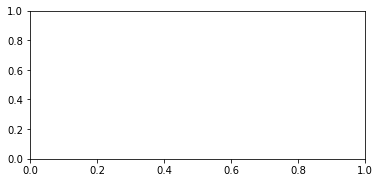

In [7]:
# Plot pulses
N = len(init_pulse)
fig1 = plt.figure()
gs = fig1.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*t*np.arange(N)/(N*2*np.pi)

axPulses = fig1.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulse, tSpace, final_pulse)
axPulses.legend(['original pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig1.add_subplot(gs[1])
axDiff.plot(tSpace, diff)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig1.set_size_inches(12,8)

In [13]:
# CRAB optimize

no_crab_coeff = 4
coeff = np.zeros(no_crab_coeff * 2)
ff = 2*np.pi / t
shift = np.random.random(no_crab_coeff) - 0.5
freq = np.zeros(no_crab_coeff)
for i in range(len(freq)):
    freq[i] = ff * (i + 1) + shift[i]

time = timer()
res = minimize(costC, coeff, args=(init_pulse, freq, h0, hd, t), method='Nelder-Mead')
time = timer()-time



In [14]:
# Print results
costFinal = res.fun
final_coeff = res.x
print('Final Fourier Coefficients: ',final_coeff)
final_pulse = crab_pulse(final_coeff, init_pulse, freq, h0, hd, t)
diff = final_pulse-init_pulse
g1Final = g1(final_pulse, h0, hd, t)
g2Final = g2(final_pulse, h0, hd, t)

print('Initial Cost: ',cost(init_pulse, h0, hd, t))
print('Frequency: ', freq)
print('Final Cost: ', costFinal)
print('G1: ', g1Final)
print('G2: ', g2Final)
print('Time: ', time)

Final Fourier Coefficients:  [ 0.01722199  0.10328865  0.02743889 -0.07120934 -0.07129489  0.10680203
 -0.02104302 -0.05499698]
Initial Cost:  0.012067627244855017
Frequency:  [ 35.5660863   69.96710943 105.73771884 140.60530599]
Final Cost:  6.577376334255118e-10
G1:  (2.19246168065608e-10-1.3085464628359058e-18j)
G2:  (1.0000000004384917-7.938599209102903e-17j)
Time:  9.541589240000008


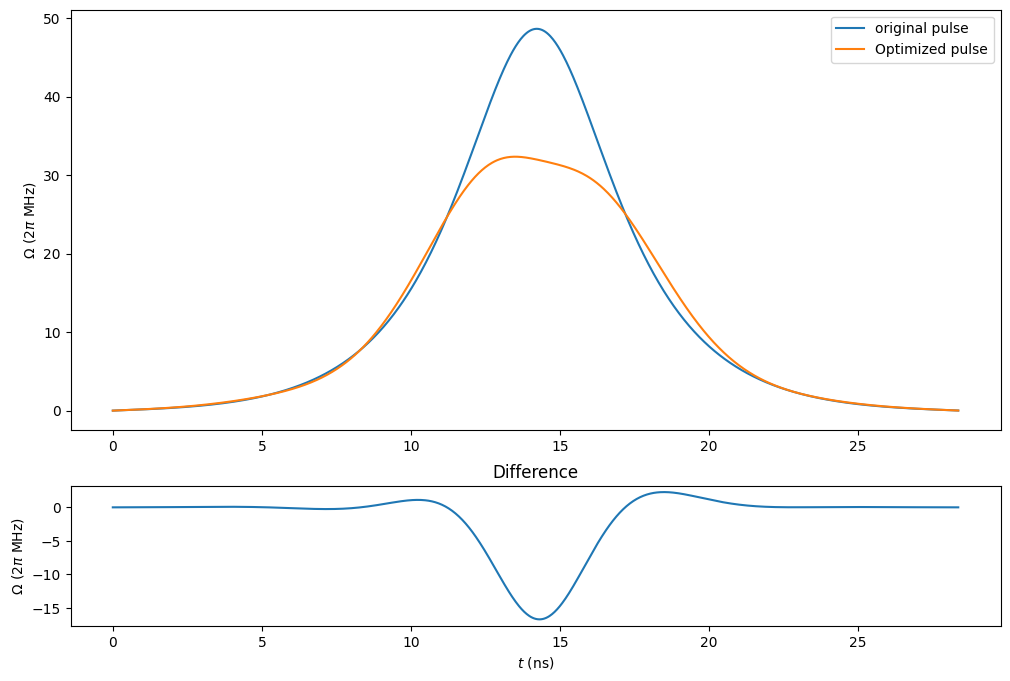

In [17]:
# Plot pulses
N = len(init_pulse)
fig1 = plt.figure()
gs = fig1.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*t*np.arange(N)/(N*2*np.pi)

axPulses = fig1.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulse, tSpace, final_pulse)
axPulses.legend(['original pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig1.add_subplot(gs[1])
axDiff.plot(tSpace, diff)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig1.set_size_inches(12,8)

In [11]:
np.savetxt('optimized_pulse_tau01783393782206284.csv', final_pulse, fmt = '%.18f')

In [143]:
fig1.savefig('opt_short_pulse.pdf')

## Plot for the paper

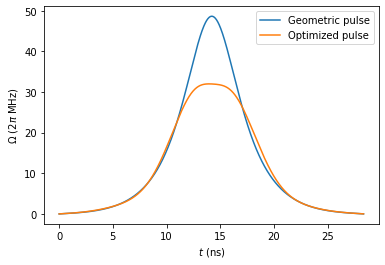

In [20]:
figPap, axPap = plt.subplots()
axPap.plot(tSpace, init_pulse, tSpace, final_pulse)
axPap.legend(['Geometric pulse', 'Optimized pulse'])
axPap.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axPap.set_xlabel(r'$t$ (ns)')

figPap.set_size_inches(6,4)

In [146]:
figPap.savefig('opt_short_pulse.pdf')

### Different duration & initial pulse

In [21]:
t2 = 0.5418448217855214

# Read in pulse from CSV
init_pulse2 = np.genfromtxt('pulse_tau05418448217855214.csv')

print('Initial Cost: ',cost(init_pulse2, h0, hd, t2))
print('G1: ', g1(init_pulse2, h0, hd, t2))
print('G2: ', g2(init_pulse2, h0, hd, t2))

Initial Cost:  0.12810391867417442
G1:  (0.04270130622472508-3.151217892635818e-14j)
G2:  (1.0854026124494494-6.297382551466793e-14j)


In [22]:
# Optimize

N = 1000
time = timer()
res2 = minimize(cost, init_pulse2, args=(h0, hd, t2), jac = gradCost,
method='L-BFGS-B')
time = timer()-time

In [23]:
# Print results
costFinal2 = res2.fun
gradFinal2 = np.linalg.norm(res2.jac)
final_pulse2 = res2.x
diff2 = final_pulse2-init_pulse2
g1Final2 = g1(final_pulse2, h0, hd, t2)
g2Final2 = g2(final_pulse2, h0, hd, t2)

print('Initial Cost: ',cost(init_pulse2, h0, hd, t2))
print('Final Cost: ', costFinal2)
print('G1: ', g1Final2)
print('G2: ', g2Final2)
print('Gradient Magnitude: ', gradFinal2)
print('Time: ', time)

Initial Cost:  0.12810391867417442
Final Cost:  2.914537665460601e-06
G1:  (9.715125553201616e-07-1.7133466495308892e-16j)
G2:  (1.0000019430251101-3.324942308430831e-16j)
Gradient Magnitude:  2.8459605026963506e-05
Time:  10.99267304300065


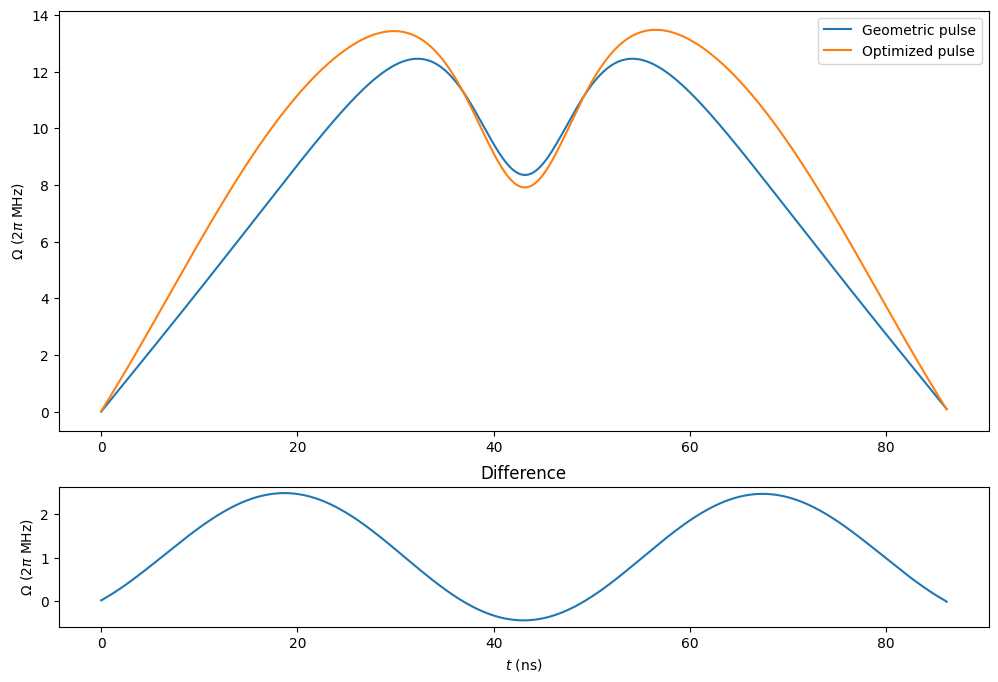

In [26]:
# Plot pulses
fig2 = plt.figure()
gs = fig2.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*t2*np.arange(N)/(N*2*np.pi)

axPulses = fig2.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulse2, tSpace, final_pulse2)
axPulses.legend(['Geometric pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig2.add_subplot(gs[1])
axDiff.plot(tSpace, diff2)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig2.set_size_inches(12,8)

In [31]:
# CRAB optimize

no_crab_coeff = 4
coeff = np.zeros(no_crab_coeff * 2)
ff = 2*np.pi / t2
shift2 = np.random.random(no_crab_coeff) - 0.5
freq2 = np.zeros(no_crab_coeff)
for i in range(len(freq2)):
    freq2[i] = ff * (i + 1) + shift2[i]

time = timer()
res2 = minimize(costC, coeff, args=(init_pulse2, freq2, h0, hd, t2), method='Nelder-Mead')
time = timer()-time


In [32]:
# Print results
costFinal2 = res2.fun
final_coeff2 = res2.x
print('Final Fourier Coefficients: ',final_coeff2)
final_pulse2 = crab_pulse(final_coeff2, init_pulse2, freq, h0, hd, t2)
diff2 = final_pulse2-init_pulse2
g1Final2 = g1(final_pulse2, h0, hd, t2)
g2Final2 = g2(final_pulse2, h0, hd, t2)

print('Initial Cost: ',cost(init_pulse2, h0, hd, t2))
print('Frequency: ', freq2)
print('Final Cost: ', costFinal2)
print('G1: ', g1Final2)
print('G2: ', g2Final2)
print('Time: ', time)

Final Fourier Coefficients:  [ 0.01056047 -0.02014113  0.03236086 -0.37415873  0.07897137  0.15546536
  0.00713677  0.0333202 ]
Initial Cost:  0.12810391867417442
Frequency:  [11.73993568 23.59797508 34.42373429 46.27670603]
Final Cost:  8.986645243764918e-10
G1:  (0.04494507021092003-3.261471281449635e-14j)
G2:  (1.0898901404218395-6.534139475910249e-14j)
Time:  2.0174159600001076


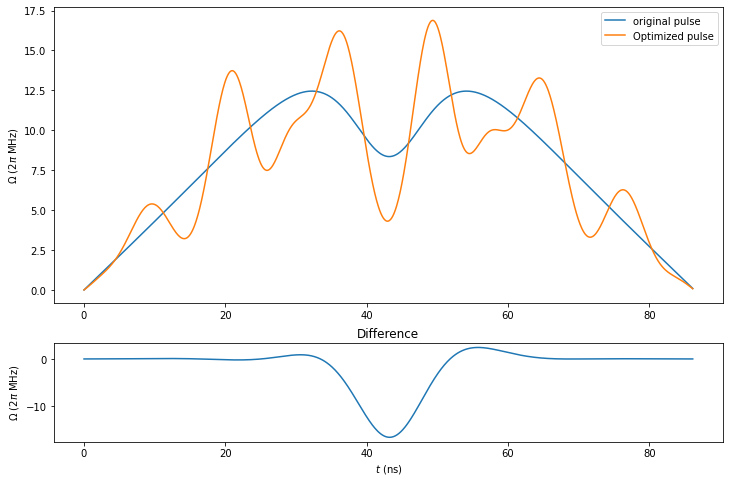

In [33]:
# Plot pulses
N = len(init_pulse2)
fig1 = plt.figure()
gs = fig1.add_gridspec(2,1,height_ratios=[3,1])
tSpace2 = 1000*t2*np.arange(N)/(N*2*np.pi)

axPulses = fig1.add_subplot(gs[0])
axPulses.plot(tSpace2, init_pulse2, tSpace2, final_pulse2)
axPulses.legend(['original pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig1.add_subplot(gs[1])
axDiff.plot(tSpace2, diff)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig1.set_size_inches(12,8)

np.savetxt('optimized_pulse_tau05418448217855214.csv', final_pulse2, fmt = '%.18f')

In [27]:
fig2.savefig('optimized_pulse_tau05418448217855214.png')

NameError: name 'fig2' is not defined

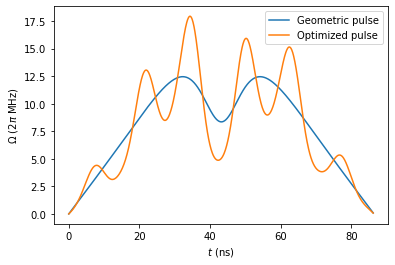

In [28]:
tSpace2 = 1000*t2*np.arange(N)/(N*2*np.pi)
figPap, axPap = plt.subplots()
axPap.plot(tSpace2, init_pulse2, tSpace2, final_pulse2)
axPap.legend(['Geometric pulse', 'Optimized pulse'])
axPap.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axPap.set_xlabel(r'$t$ (ns)')

figPap.set_size_inches(6,4)

In [148]:
figPap.savefig('opt_long_pulse.pdf')

## Chop first pulse

The first optimized pulse becomes positive - can we chop it off there?

In [21]:
np.nonzero(np.diff(np.sign(final_pulse)))

(array([ 24, 120, 862]),)

In [22]:
chopped_pulse = final_pulse[121:863]
N_chopped = len(chopped_pulse)
t_chopped = t * N_chopped/1000

print('Cost: ', cost(chopped_pulse, h0, hd, t_chopped))
print('G1: ', g1(chopped_pulse, h0, hd, t_chopped))
print('G2: ', g2(chopped_pulse, h0, hd, t_chopped))

Cost:  0.4101886387505945
G1:  (0.13672954625031739+3.354003199966804e-14j)
G2:  (1.2734590925002771+6.67973459795408e-14j)


Still need time to evolve under free Hamiltonian

In [23]:
chopped_pulse = np.zeros(1000)
chopped_pulse[121:863] = final_pulse[121:863]

print('Cost: ', cost(chopped_pulse, h0, hd, t))
print('G1: ', g1(chopped_pulse, h0, hd, t))
print('G2: ', g2(chopped_pulse, h0, hd, t))

Cost:  0.0001176354349557369
G1:  (3.9211811812261506e-05+7.605644232316864e-16j)
G2:  (1.0000784236231435+1.8400943240748183e-15j)


Makhlin invariants still match within $10^{-4}$

## Sine Pulse

Trying a sine wave pulse to see how it compares to the geometric curves

In [24]:
tSine = 0.24

# Read in pulse from CSV
init_pulseSine = np.genfromtxt('pulse_test_tau024.csv')

print('Initial Cost: ',cost(init_pulseSine, h0, hd, tSine))
print('G1: ', g1(init_pulseSine, h0, hd, tSine))
print('G2: ', g2(init_pulseSine, h0, hd, tSine))

Initial Cost:  1.4214773256270208
G1:  (0.4738257752092635-8.965280059059529e-15j)
G2:  (1.9476515504177574-1.637670615406662e-14j)


In [25]:
# Optimize

N = 1000
time = timer()
resSine = minimize(cost, init_pulseSine, args=(h0, hd, tSine), jac = gradCost,
method='L-BFGS-B')
time = timer()-time

In [26]:
# Print results
costFinalSine = resSine.fun
gradFinalSine = np.linalg.norm(resSine.jac)
final_pulseSine = resSine.x
diffSine = final_pulseSine-init_pulseSine
g1FinalSine = g1(final_pulseSine, h0, hd, tSine)
g2FinalSine = g2(final_pulseSine, h0, hd, tSine)

print('Initial Cost: ',cost(init_pulseSine, h0, hd, tSine))
print('Final Cost: ', costFinalSine)
print('G1: ', g1FinalSine)
print('G2: ', g2FinalSine)
print('Gradient Magnitude: ', gradFinalSine)
print('Time: ', time)

Initial Cost:  1.4214773256270208
Final Cost:  4.347967503944836e-07
G1:  (1.449325057875092e-07+3.0072396212426094e-17j)
G2:  (1.0000002898642446+9.238189199330238e-16j)
Gradient Magnitude:  2.102468252382692e-05
Time:  38.46071075599997


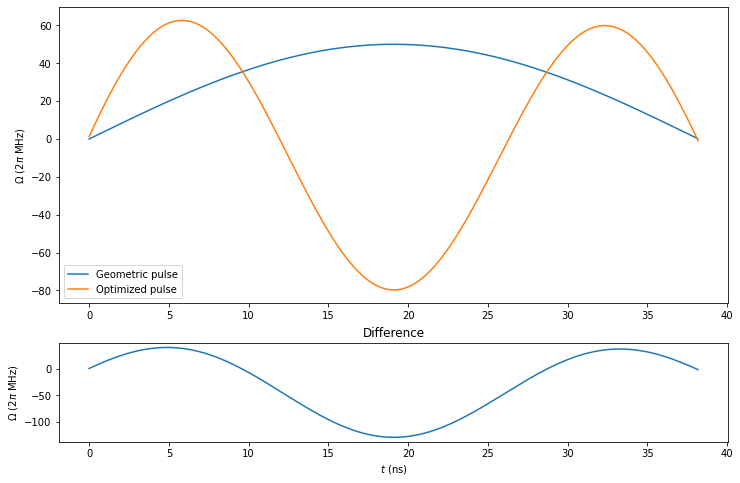

In [27]:
# Plot pulses
figSine = plt.figure()
gs = figSine.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*tSine*np.arange(N)/(N*2*np.pi)

axPulses = figSine.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulseSine, tSpace, final_pulseSine)
axPulses.legend(['Geometric pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = figSine.add_subplot(gs[1])
axDiff.plot(tSpace, diffSine)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

figSine.set_size_inches(12,8)

In [28]:
np.savetxt('optimized_pulse_test_tau024.csv', final_pulseSine, fmt = '%.18f')

In [29]:
fig2.savefig('optimized_pulse_test_tau024.pdf')

## Slepians

What do you get starting from a random superposition of slepian sequences?

(Gate time is arbitrary right now - take to be the same as $\tau_2 = 0.542~\mu s$)

In [43]:
from scipy.signal.windows import dpss

t = 0.1783393782206284

w = .05
N = 1000
slep,ratios = dpss(N, w*N, Kmax=int(np.floor(2*N*w)), return_ratios=True)
slep = np.ascontiguousarray(slep)
# Throw out sequences with lambda <= .99 to force signal to start and end near 0
Kmax = np.where(ratios <= .99)[0][0]
slep = slep[:Kmax,:]
ratios = ratios[:Kmax]

init_pulseSlep = 15*np.random.random(Kmax) @ slep
tSlep = t2

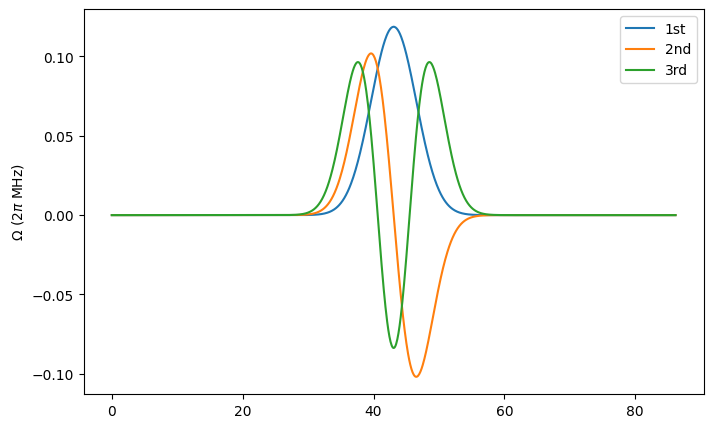

In [44]:
# Plot pulses
figSlep = plt.figure()
gs = figSlep.add_gridspec(1,1)
tSpace = 1000*tSlep*np.arange(N)/(N*2*np.pi)

axPulses = figSlep.add_subplot(gs[0])
axPulses.plot(tSpace, slep[0,:], tSpace, slep[1,:], tSpace, slep[2,:])
axPulses.legend(['1st', '2nd', '3rd'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

figSlep.set_size_inches(8,5)

In [45]:
# Optimize

N = 1000
time = timer()
resSlep = minimize(cost, init_pulseSlep, args=(h0, hd, tSlep), jac = gradCost,
method='L-BFGS-B')
time = timer()-time

In [46]:
# Print results
costFinalSlep = resSlep.fun
gradFinalSlep = np.linalg.norm(resSlep.jac)
final_pulseSlep = resSlep.x
diffSlep = final_pulseSlep-init_pulseSlep
g1FinalSlep = g1(final_pulseSlep, h0, hd, tSlep)
g2FinalSlep = g2(final_pulseSlep, h0, hd, tSlep)

print('Initial Cost: ',cost(init_pulseSlep, h0, hd, tSlep))
print('Final Cost: ', costFinalSlep)
print('G1: ', g1FinalSlep)
print('G2: ', g2FinalSlep)
print('Gradient Magnitude: ', gradFinalSlep)
print('Time: ', time)

Initial Cost:  0.9737109578296537
Final Cost:  4.8855601713027905e-06
G1:  (1.6285200572453157e-06-1.366165552104207e-16j)
G2:  (1.000003257040114-1.4698759113891957e-16j)
Gradient Magnitude:  3.2100869926135475e-05
Time:  21.068602646002546


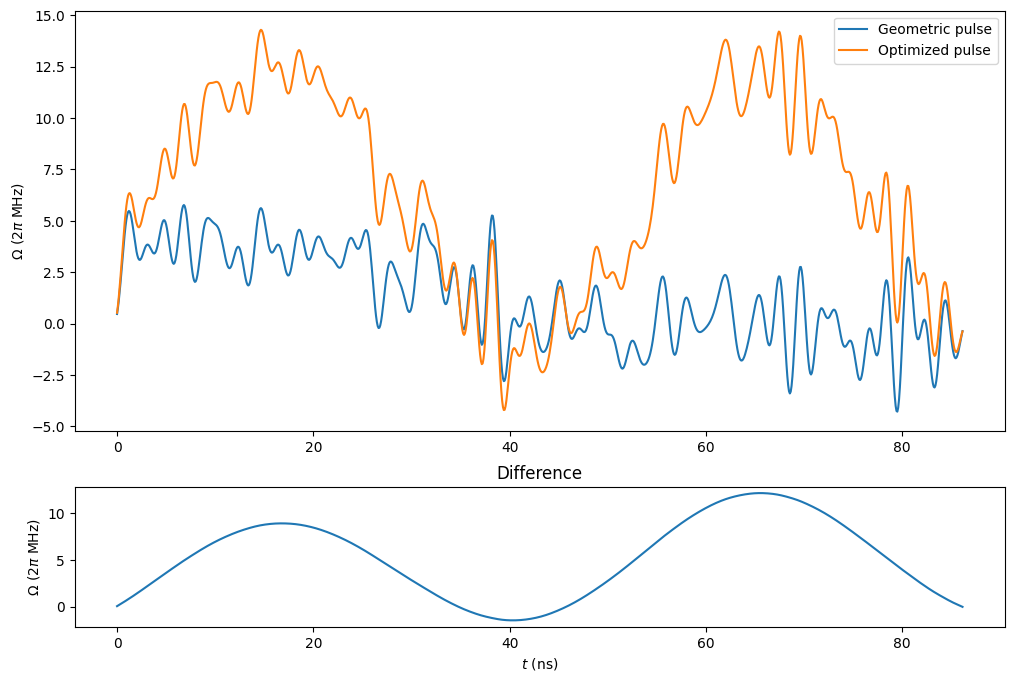

In [47]:
# Plot pulses
figSlep = plt.figure()
gs = figSlep.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*tSlep*np.arange(N)/(N*2*np.pi)

axPulses = figSlep.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulseSlep, tSpace, final_pulseSlep)
axPulses.legend(['Geometric pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = figSlep.add_subplot(gs[1])
axDiff.plot(tSpace, diffSlep)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

figSlep.set_size_inches(12,8)

In [40]:
# CRAB optimize

no_crab_coeff = 4
coeff = np.zeros(no_crab_coeff * 2)
ff = 2*np.pi / t
shift = np.random.random(no_crab_coeff) - 0.5
freq = np.zeros(no_crab_coeff)
for i in range(len(freq)):
    freq[i] = ff * (i + 1) + shift[i]

time = timer()
res = minimize(costC, coeff, args=(init_pulseSlep, freq, h0, hd, tSlep), method='Nelder-Mead')
time = timer()-time


In [41]:
# Print results
costFinal = res.fun
final_coeff = res.x
print('Final Fourier Coefficients: ',final_coeff)
final_pulse = crab_pulse(final_coeff, init_pulseSlep, freq, h0, hd, tSlep)
diff = final_pulse-init_pulse
g1Final = g1(final_pulse, h0, hd, tSlep)
g2Final = g2(final_pulse, h0, hd, tSlep)

print('Initial Cost: ',cost(init_pulseSlep, h0, hd, tSlep))
print('Frequency: ', freq)
print('Final Cost: ', costFinal)
print('G1: ', g1Final)
print('G2: ', g2Final)
print('Time: ', time)

Final Fourier Coefficients:  [ 9.45649952  2.40681655 -2.36945278 -6.65742678  3.84069829  2.88477301
 -4.40717996 -4.64417951]
Initial Cost:  0.1006137826012049
Frequency:  [ 35.47267562  70.37605875 105.81855865 140.76412964]
Final Cost:  3.194821638232731e-12
G1:  (1.0651918325110997e-12+8.977659655527266e-20j)
G2:  (1.0000000000021299+4.927652964328936e-17j)
Time:  2.890810183947906


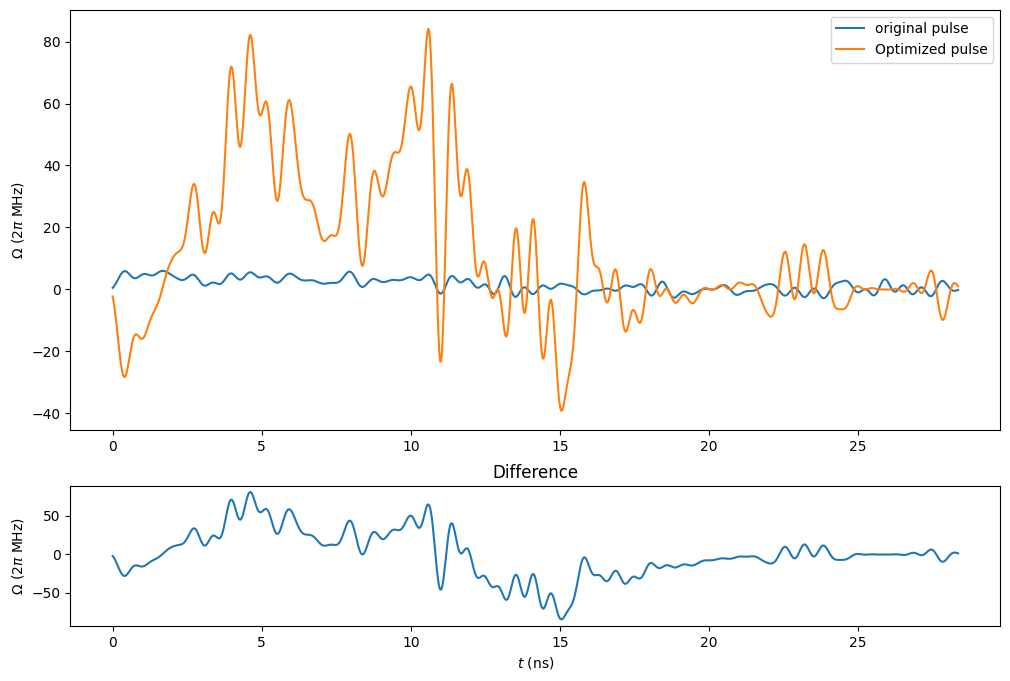

In [42]:
# Plot pulses
N = len(init_pulseSlep)
fig1 = plt.figure()
gs = fig1.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*tSlep*np.arange(N)/(N*2*np.pi)

axPulses = fig1.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulseSlep, tSpace, final_pulse)
axPulses.legend(['original pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig1.add_subplot(gs[1])
axDiff.plot(tSpace, diff)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig1.set_size_inches(12,8)

Smaller bandwidth

In [48]:
w = .01
N = 1000
slep,ratios = dpss(N, w*N, Kmax=int(np.floor(2*N*w)), return_ratios=True)
slep = np.ascontiguousarray(slep)
# Throw out sequences with lambda <= .99 to force signal to start and end near 0
Kmax = np.where(ratios <= .99)[0][0]
slep = slep[:Kmax,:]
ratios = ratios[:Kmax]

init_pulseSlep2 = 15*np.random.random(Kmax) @ slep
tSlep2 = t2

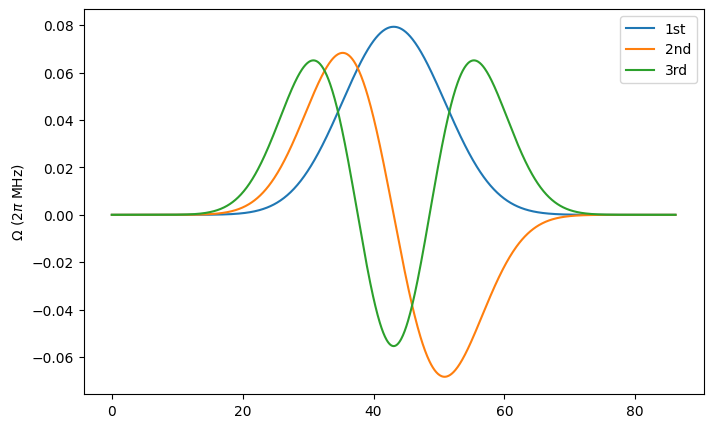

In [49]:
# Plot pulses
figSlep = plt.figure()
gs = figSlep.add_gridspec(1,1)
tSpace = 1000*tSlep*np.arange(N)/(N*2*np.pi)

axPulses = figSlep.add_subplot(gs[0])
axPulses.plot(tSpace, slep[0,:], tSpace, slep[1,:], tSpace, slep[2,:])
axPulses.legend(['1st', '2nd', '3rd'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

figSlep.set_size_inches(8,5)

In [50]:
# Optimize

N = 1000
time = timer()
resSlep2 = minimize(cost, init_pulseSlep2, args=(h0, hd, tSlep2), jac = gradCost,
method='L-BFGS-B')
time = timer()-time

In [51]:
# Print results
costFinalSlep2 = resSlep2.fun
gradFinalSlep2 = np.linalg.norm(resSlep2.jac)
final_pulseSlep2 = resSlep2.x
diffSlep2 = final_pulseSlep2-init_pulseSlep2
g1FinalSlep2 = g1(final_pulseSlep2, h0, hd, tSlep2)
g2FinalSlep2 = g2(final_pulseSlep2, h0, hd, tSlep2)

print('Initial Cost: ',cost(init_pulseSlep2, h0, hd, tSlep2))
print('Final Cost: ', costFinalSlep2)
print('G1: ', g1FinalSlep2)
print('G2: ', g2FinalSlep2)
print('Gradient Magnitude: ', gradFinalSlep2)
print('Time: ', time)

Initial Cost:  1.0185156306911805
Final Cost:  1.385154870991346e-07
G1:  (4.61718292676284e-08-1.9639529374687822e-17j)
G2:  (1.0000000923436578-1.0605614383696683e-16j)
Gradient Magnitude:  2.1297706862512265e-05
Time:  21.765000257873908


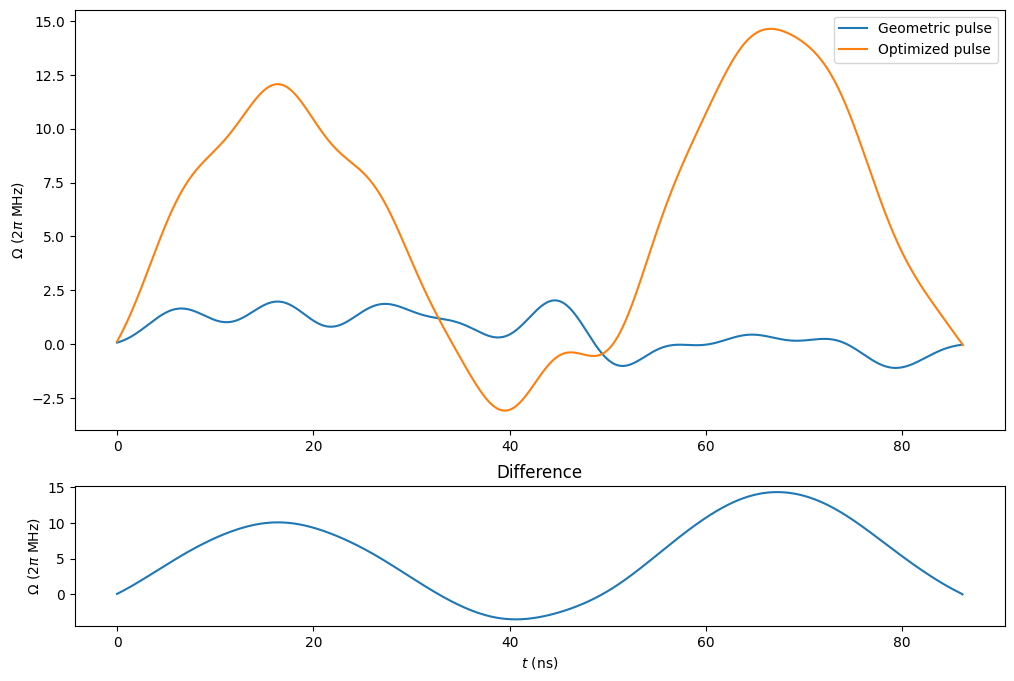

In [52]:
# Plot pulses
figSlep2 = plt.figure()
gs = figSlep2.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*tSlep2*np.arange(N)/(N*2*np.pi)

axPulses = figSlep2.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulseSlep2, tSpace, final_pulseSlep2)
axPulses.legend(['Geometric pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = figSlep2.add_subplot(gs[1])
axDiff.plot(tSpace, diffSlep2)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

figSlep2.set_size_inches(12,8)

In [53]:
# CRAB optimize

no_crab_coeff = 4
coeff = np.zeros(no_crab_coeff * 2)
ff = 2*np.pi / t
shift = np.random.random(no_crab_coeff) - 0.5
freq = np.zeros(no_crab_coeff)
for i in range(len(freq)):
    freq[i] = ff * (i + 1) + shift[i]

time = timer()
res = minimize(costC, coeff, args=(init_pulseSlep, freq, h0, hd, tSlep), method='Nelder-Mead')
time = timer()-time

In [54]:
# Print results
costFinal = res.fun
final_coeff = res.x
print('Final Fourier Coefficients: ',final_coeff)
final_pulse = crab_pulse(final_coeff, init_pulseSlep, freq, h0, hd, tSlep)
diff = final_pulse-init_pulse
g1Final = g1(final_pulse, h0, hd, tSlep)
g2Final = g2(final_pulse, h0, hd, tSlep)

print('Initial Cost: ',cost(init_pulseSlep, h0, hd, tSlep))
print('Frequency: ', freq)
print('Final Cost: ', costFinal)
print('G1: ', g1Final)
print('G2: ', g2Final)
print('Time: ', time)

Final Fourier Coefficients:  [ -0.64977526 -16.66225088   1.88610671  -0.43628939   3.11382092
  -0.62559877   6.32644767   2.40797197]
Initial Cost:  0.9737109578296537
Frequency:  [ 35.2814022   70.49787577 105.74386977 141.1640827 ]
Final Cost:  5.129128135897943e-12
G1:  (1.7098632630735603e-12+1.4473917047467483e-19j)
G2:  (1.0000000000034188+7.159449769653407e-18j)
Time:  2.783695242134854


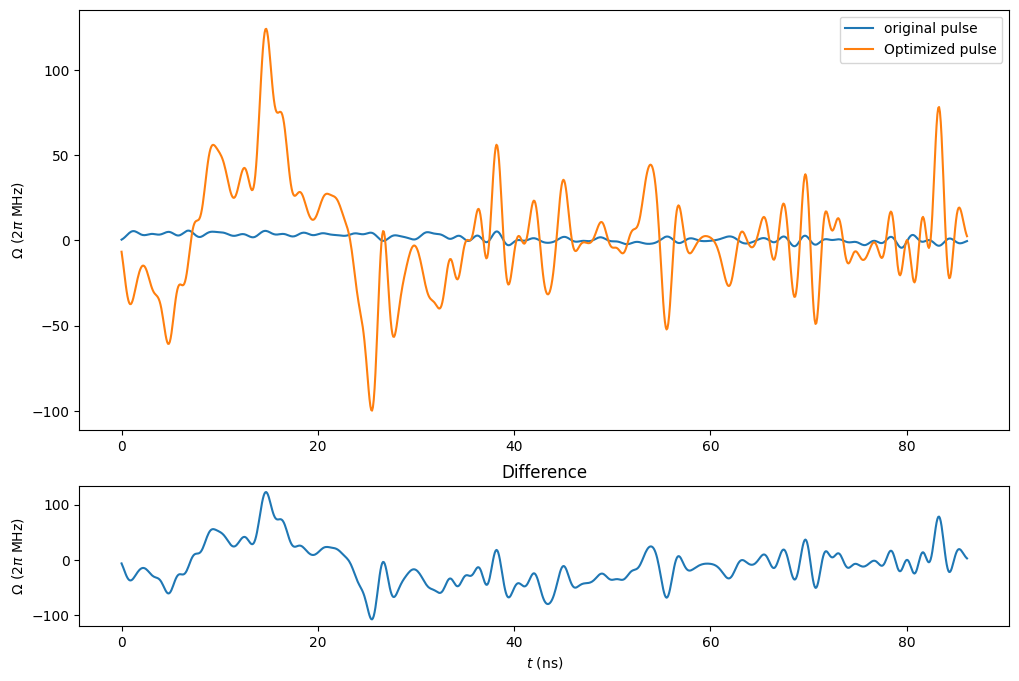

In [55]:
# Plot pulses
N = len(init_pulseSlep)
fig1 = plt.figure()
gs = fig1.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*tSlep*np.arange(N)/(N*2*np.pi)

axPulses = fig1.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulseSlep, tSpace, final_pulse)
axPulses.legend(['original pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig1.add_subplot(gs[1])
axDiff.plot(tSpace, diff)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig1.set_size_inches(12,8)

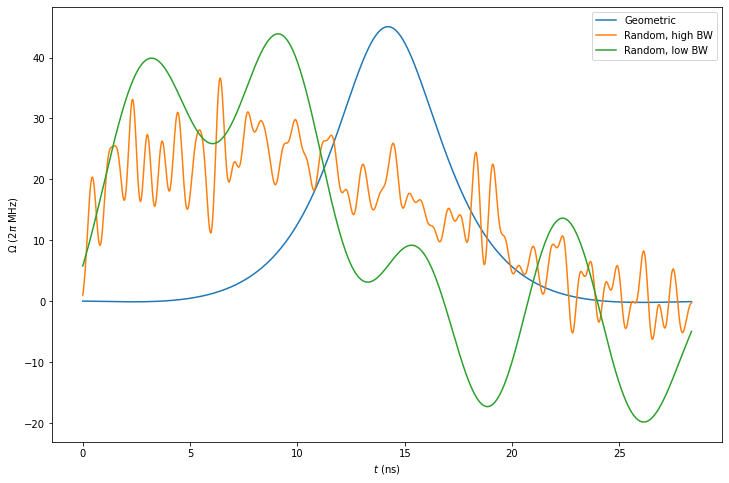

In [127]:
figComp2, ax = plt.subplots()
tSpace = 1000*t*np.arange(N)/(N*2*np.pi)
ax.plot(tSpace, final_pulse, 
         tSpace, final_pulseSlep3, 
         tSpace, final_pulseSlep4)
ax.legend(['Geometric', 'Random, high BW', 'Random, low BW'])
ax.set_xlabel('$t$ (ns)')
ax.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
figComp2.set_size_inches(12,8)

In [33]:
print(costFinal)
print(costFinalSlep)
print(costFinalSlep2)

0.00011367557867917162
0.00036536006205191223
0.09540930814657472


In [128]:
figComp2.savefig('comparison_tau0178.pdf')

Bandwidth of short geometric pulse

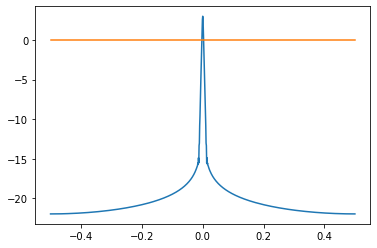

In [101]:
def ft(f):
    return final_pulse @ np.exp(-2j*np.pi*f*np.arange(1000))

fspace = np.linspace(-1/2,1/2,1001)
logspec = np.array([np.log(np.abs(ft(f))**2/np.abs(ft(0))**2)+3 for f in fspace])
plt.plot(fspace, logspec, fspace, np.zeros(1001))

In [106]:
from scipy.optimize import root
bw = 2*(root(lambda f: np.log(np.abs(ft(f))**2/np.abs(ft(0))**2)+3, .01).x)
bw

array([0.0057879])

## Presentation plots

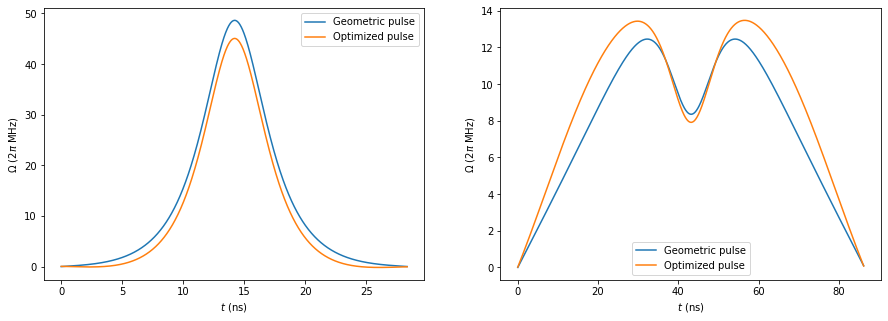

In [41]:
figPres, ax = plt.subplots(1,2)

tSpace1 = 1000*t*np.arange(N)/(N*2*np.pi)
ax[0].plot(tSpace1, init_pulse, tSpace1, final_pulse)
ax[0].legend(['Geometric pulse', 'Optimized pulse'])
ax[0].set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
ax[0].set_xlabel(r'$t$ (ns)')

tSpace2 = 1000*t2*np.arange(N)/(N*2*np.pi)
ax[1].plot(tSpace2, init_pulse2, tSpace2, final_pulse2)
ax[1].legend(['Geometric pulse', 'Optimized pulse'])
ax[1].set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
ax[1].set_xlabel(r'$t$ (ns)')

figPres.set_size_inches(15,5)
figPres.savefig('presentation_fig.png')

## Gradient of the cost function

Since $\text{Tr}~H = 0, \det U = 1$, and the cost function simplifies to

$$ C = |G_1| + |1-G_2| = \left| \frac{\text{Tr}(M)^2}{16} \right| + \left| 1-\frac{\text{Tr}(M)^2 - \text{Tr}(M^2)}{4} \right|. $$

With $\Omega_j \equiv \Omega(j \Delta t)$, $U_j \equiv e^{-i \Delta t H(\Omega_j)}$, $U_{k:j} \equiv U_k U_{k-1} \cdots U_{j+1} U_j$, such that $U_{N-1:0} = U$, we have

$$ \frac{\partial C}{\partial \Omega_j} = \frac{1}{8} \Re \left[ \text{Tr}(M)\text{Tr} \left( \frac{\partial M}{\partial \Omega_j} \right) \left( e^{-i \arg(G_1)} - 4e^{-i \arg(1-G_2)} \right) + \text{Tr}\left( M\frac{\partial M}{\partial \Omega_j} \right) 4e^{-i \arg(1-G_2)} \right],$$

$$ \frac{\partial M}{\partial \Omega_j} = \left( \frac{\partial U_B}{\partial \Omega_j} \right)^T U_B + U_B^T \frac{\partial U_B}{\partial \Omega_j} = U_B^T Q^\dagger U_{N-1:j+1} \frac{\partial U_j}{\partial \Omega_j} U_{j-1:0} Q + \text{tr.} = -i \Delta t ~ U_B^T Q^\dagger U_{N-1:j+1} H_d U_{j:0} Q + \text{tr.} $$

## Use Hamiltonian with less approximations

Using only RWA approximation,

$$ H_{RWA} = \begin{pmatrix}
    \frac{1}{2}(\Delta - \delta_- J) & \frac{\delta_+}{4}\Omega & \frac{\delta_-}{4}\Omega & 0 \\
    \frac{\delta_+}{4}\Omega & \frac{1}{2}(\Delta - \delta_- J) & 0 & \frac{\delta_+}{4}\Omega \\
    \frac{\delta_-}{4}\Omega & 0 & -\frac{1}{2}(\Delta + \delta_+ J) & \frac{\delta_-}{4}\Omega\\
    0 & \frac{\delta_+}{4}\Omega & \frac{\delta_-}{4}\Omega & -\frac{1}{2}(\Delta - \delta_- J)
\end{pmatrix}, $$

Where $\Delta = \Delta E_z + \Delta E_z^1, \delta_\pm = 1 \pm \frac{J}{2\Delta}$.

In [20]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from double_qd_trotter_funcs import *

In [21]:
# Initialize Hamiltonian
Delta = 214-46.94
J=19.7
deltap = 1 + J/(2*Delta)
deltam = 1 - J/(2*Delta)
h0diag = np.array([(Delta - deltam*J)/2, (Delta - deltam*J)/2, -(Delta + deltap*J)/2, -(Delta - deltam*J)/2], dtype='complex128')
dipoles1 = np.array([deltap/4, 0, deltam/4], dtype='complex128')
dipoles2 = np.array([deltam/4, deltap/4], dtype='complex128')
h0 = np.diag(h0diag)
hd = np.diag(dipoles1,1)+np.diag(dipoles1,-1)+np.diag(dipoles2,2)+np.diag(dipoles2,-2)
t = 0.1783393782206284

# Compile JIT functions
pulse = np.random.random(5)
_ = uGRAPE(pulse, h0, hd, t)
_ = duG(0, pulse, h0, hd, t)
_ = mG(pulse, h0, hd, t)
_ = dmG(0, pulse, h0, hd, t)
_ = g1G(pulse, h0, hd, t)
_ = g2G(pulse, h0, hd, t)
_ = costG(pulse, h0, hd, t)
_ = gradCostG(pulse, h0, hd, t)

In [32]:
from scipy.linalg import expm
ed,ev = np.linalg.eig(h0 + hd)
np.allclose(ev * np.exp(-1j * ed) @ ev.T.conj(), expm(-1j * (h0 + hd)))

True

In [31]:
ev.T

array([[ 5.00000000e-01-0.j,  5.28562481e-01+0.j,  4.69703847e-01-0.j,
         5.00000000e-01-0.j],
       [-5.00000000e-01+0.j,  5.28562481e-01+0.j,  4.69703847e-01-0.j,
        -5.00000000e-01+0.j],
       [-1.37701167e-08+0.j, -6.64261551e-01+0.j,  7.47500229e-01+0.j,
         1.37701166e-08+0.j],
       [ 1.37701160e-08+0.j, -6.64261551e-01+0.j,  7.47500229e-01+0.j,
        -1.37701160e-08+0.j]])

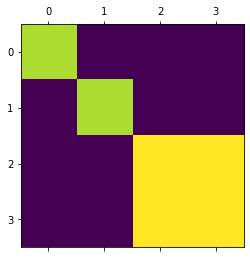

In [29]:
plt.matshow(np.real(ev.T.conj() @ expm(-1j * hd) @ ev))

In [5]:
utest = uGRAPE(pulse, h0, hd, t)
np.trace(utest.T.conj() @ utest)/4

(0.9999999999999996+0j)

In [15]:
t = 0.1783393782206284

# Read in pulse from CSV
init_pulse = np.genfromtxt('optimized_pulse_tau01783393782206284.csv')

print('Initial Cost: ',costG(init_pulse, h0, hd, t))
print('G1: ', g1G(init_pulse, h0, hd, t))
print('G2: ', g2G(init_pulse, h0, hd, t))

Initial Cost:  0.0015937018325197748
G1:  (0.0003573357108210176+3.728993134328238e-06j)
G2:  (0.9987636533348107+2.4256916097553667e-12j)


In [16]:
# Optimize

N = 1000
time = timer()
res = minimize(costG, init_pulse, args=(h0, hd, t), jac = gradCostG,
method='L-BFGS-B')
time = timer()-time

In [17]:
# Print results
costFinal = res.fun
gradFinal = np.linalg.norm(res.jac)
final_pulse = res.x
diff = final_pulse-init_pulse
g1Final = g1G(final_pulse, h0, hd, t)
g2Final = g2G(final_pulse, h0, hd, t)

print('Initial Cost: ',costG(init_pulse, h0, hd, t))
print('Final Cost: ', costFinal)
print('G1: ', g1Final)
print('G2: ', g2Final)
print('Gradient Magnitude: ', gradFinal)
print('Time: ', time)

Initial Cost:  0.0015937018325197748
Final Cost:  0.0015937018325197748
G1:  (0.0003573357108210176+3.728993134328238e-06j)
G2:  (0.9987636533348107+2.4256916097553667e-12j)
Gradient Magnitude:  6.862538920711601e-05
Time:  23.90421797900001


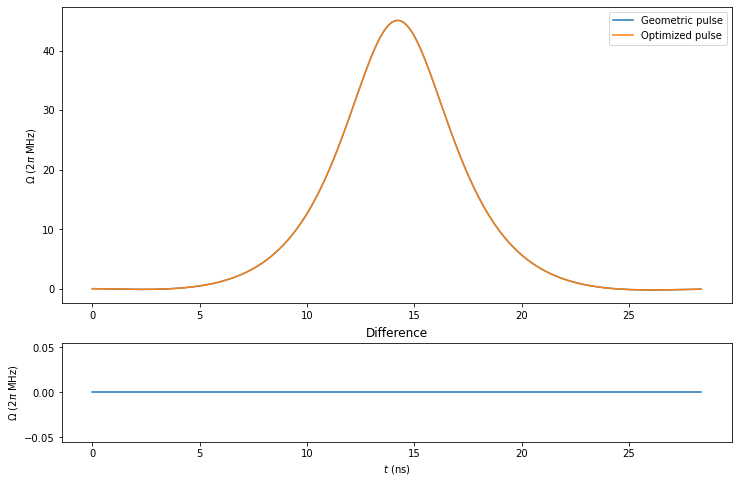

In [18]:
# Plot pulses
fig1 = plt.figure()
gs = fig1.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*t*np.arange(N)/(N*2*np.pi)

axPulses = fig1.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulse, tSpace, final_pulse)
axPulses.legend(['Geometric pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig1.add_subplot(gs[1])
axDiff.plot(tSpace, diff)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig1.set_size_inches(12,8)

### Different duration & initial pulse

In [24]:
t2 = 0.5418448217855214

# Read in pulse from CSV
init_pulse2 = np.genfromtxt('optimized_pulse_tau05418448217855214.csv')

print('Initial Cost: ',costG(init_pulse2, h0, hd, t2))
print('G1: ', g1G(init_pulse, h0, hd, t2))
print('G2: ', g2G(init_pulse, h0, hd, t2))

Initial Cost:  0.005272458704175908
G1:  (0.3386309734122084-1.1123465052715482e-08j)
G2:  (1.6772619030483176-1.7923095462871081e-12j)


In [25]:
# Optimize

N = 1000
time = timer()
res2 = minimize(costG, init_pulse2, args=(h0, hd, t2), jac = gradCostG,
method='L-BFGS-B')
time = timer()-time

In [26]:
# Print results
costFinal2 = res2.fun
gradFinal2 = np.linalg.norm(res2.jac)
final_pulse2 = res2.x
diff2 = final_pulse2-init_pulse2
g1Final2 = g1G(final_pulse2, h0, hd, t2)
g2Final2 = g2G(final_pulse2, h0, hd, t2)

print('Initial Cost: ',costG(init_pulse2, h0, hd, t2))
print('Final Cost: ', costFinal2)
print('G1: ', g1Final2)
print('G2: ', g2Final2)
print('Gradient Magnitude: ', gradFinal2)
print('Time: ', time)

Initial Cost:  0.005272458704175908
Final Cost:  0.005272458704175647
G1:  (0.001757544102661832-3.504610641433172e-09j)
G2:  (1.0035149146015103-4.829986640253033e-14j)
Gradient Magnitude:  0.00035055543131068303
Time:  395.51450171798933


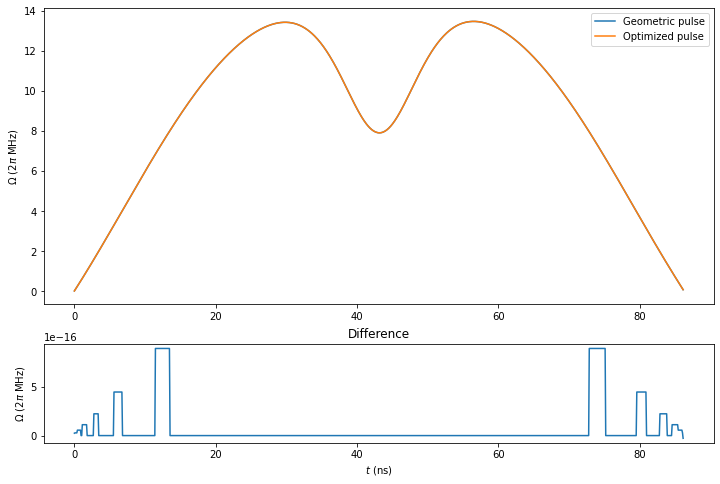

In [27]:
# Plot pulses
fig2 = plt.figure()
gs = fig2.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*t2*np.arange(N)/(N*2*np.pi)

axPulses = fig2.add_subplot(gs[0])
axPulses.plot(tSpace, init_pulse2, tSpace, final_pulse2)
axPulses.legend(['Geometric pulse', 'Optimized pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = fig2.add_subplot(gs[1])
axDiff.plot(tSpace, diff2)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

fig2.set_size_inches(12,8)

## Bandwidth of geometric pulse

I calculated in Mathematica that the -3dB bandwidth of the geometric pulse is $w = .03$; how well does a Slepian sequence with that bandwidth match the original pulse?

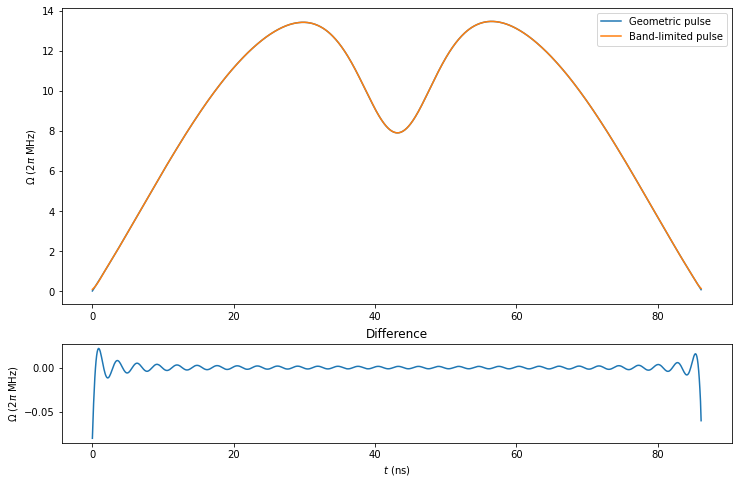

In [40]:
from scipy.signal.windows import dpss

w = .03
N = 1000
Kmax=int(np.floor(2*N*w))
slep,ratios = dpss(N, w*N, Kmax=Kmax, return_ratios=True)
slep = np.ascontiguousarray(slep)

geo_pulse2 = np.genfromtxt('optimized_pulse_tau05418448217855214.csv')
band_lim_pulse2 = slep @ geo_pulse2 @ slep

figSG = plt.figure()
gs = figSG.add_gridspec(2,1,height_ratios=[3,1])
tSpace = 1000*t2*np.arange(N)/(N*2*np.pi)

axPulses = figSG.add_subplot(gs[0])
axPulses.plot(tSpace, geo_pulse2, tSpace, band_lim_pulse2)
axPulses.legend(['Geometric pulse', 'Band-limited pulse'])
axPulses.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')

axDiff = figSG.add_subplot(gs[1])
axDiff.plot(tSpace, geo_pulse2 - band_lim_pulse2)
axDiff.set_title('Difference')
axDiff.set_ylabel(r'$\Omega$ ($2 \pi$ MHz)')
axDiff.set_xlabel(r'$t$ (ns)')

figSG.set_size_inches(12,8)

<BarContainer object of 60 artists>

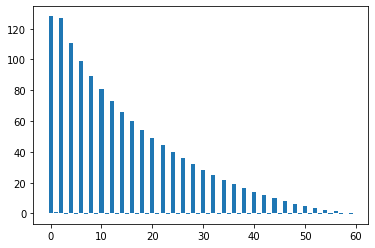

In [41]:
plt.bar(np.arange(Kmax), slep @ geo_pulse2)

In [130]:
utrotter(final_pulse, h0, hd, t)

array([[ 8.93028161e-01-2.40640841e-14j,  4.79616347e-14-4.50000783e-01j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 4.73510120e-14-4.50000783e-01j,  8.93028161e-01-2.40918396e-14j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -2.05833632e-01+8.82845232e-01j, -7.03130637e-04-4.22156745e-01j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         7.03130637e-04-4.22156745e-01j, -2.05833632e-01-8.82845232e-01j]])

In [132]:
np.savetxt('re_u_opt_short.csv', np.real(utrotter(final_pulse, h0, hd, t)), fmt='%.18f', delimiter=',')
np.savetxt('im_u_opt_short.csv', np.imag(utrotter(final_pulse, h0, hd, t)), fmt='%.18f', delimiter=',')

In [133]:
np.savetxt('re_u_opt_long.csv', np.real(utrotter(final_pulse2, h0, hd, t2)), fmt='%.18f', delimiter=',')
np.savetxt('im_u_opt_long.csv', np.imag(utrotter(final_pulse2, h0, hd, t2)), fmt='%.18f', delimiter=',')

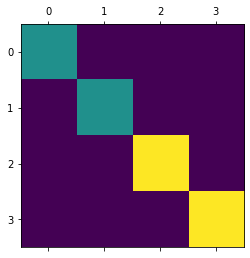

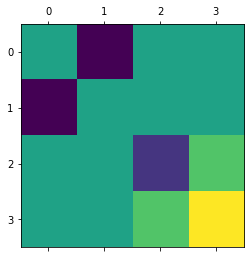

In [135]:
plt.matshow(np.real(utrotter(final_pulse2, h0, hd, t2)))
plt.matshow(np.imag(utrotter(final_pulse2, h0, hd, t2)))

In [137]:
from double_qd_trotter_funcs import *

# Initialize Hamiltonian
Delta = 214-46.94
J=19.7
deltap = 1 + J/(2*Delta)
deltam = 1 - J/(2*Delta)
h0diagFull = np.array([(Delta - deltam*J)/2, (Delta - deltam*J)/2, -(Delta + deltap*J)/2, -(Delta - deltam*J)/2], dtype='complex128')
dipoles1Full = np.array([deltap/4, 0, deltam/4], dtype='complex128')
dipoles2Full = np.array([deltam/4, deltap/4], dtype='complex128')
h0Full = np.diag(h0diagFull)
hdFull = np.diag(dipoles1Full,1)+np.diag(dipoles1Full,-1)+np.diag(dipoles2Full,2)+np.diag(dipoles2Full,-2)
t = 0.1783393782206284

uGRAPE(final_pulse, h0Full, hdFull, t)

array([[ 0.67515775-0.56479928j, -0.30590153-0.3619939j ,
         0.01804748+0.00532229j, -0.01371781+0.00250045j],
       [-0.30591399-0.36198113j,  0.66889323-0.57140125j,
         0.00254088-0.01273498j,  0.00166219-0.03601879j],
       [ 0.01840229+0.00386054j,  0.00147603-0.01289616j,
        -0.41047425-0.81945261j,  0.25258479+0.30933347j],
       [-0.01355083+0.00359328j, -0.00127312-0.03601424j,
         0.2515523 +0.31017266j,  0.71867844+0.56790887j]])

In [138]:
np.savetxt('re_u_opt_short.csv', np.real(uGRAPE(final_pulse, h0Full, hdFull, t)), fmt='%.18f', delimiter=',')
np.savetxt('im_u_opt_short.csv', np.imag(uGRAPE(final_pulse, h0Full, hdFull, t)), fmt='%.18f', delimiter=',')

In [139]:
np.savetxt('re_u_opt_long.csv', np.real(uGRAPE(final_pulse2, h0Full, hdFull, t2)), fmt='%.18f', delimiter=',')
np.savetxt('im_u_opt_long.csv', np.imag(uGRAPE(final_pulse2, h0Full, hdFull, t2)), fmt='%.18f', delimiter=',')